<a href="https://colab.research.google.com/github/navendano11/NLP/blob/master/Prueba_T%C3%A9cnica_Machine_Learning_Engineer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prueba técniva_ ML Engineer

# I. Introduction

Se creará la recomendación de chistes basados en la base de datos [Joke]((http://eigentaste.berkeley.edu/dataset/)). Se utiliza el **Dataset 1** y ratings de **jester_dataset_1_1.zip: **. Lo datos consisten en 100 chistes calificados en la escala de -10 a 10.

## Setup

Se cargan las librerias necesarias

In [151]:
# @title Imports (run this cell)
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

# Install spreadsheets and import authentication module.
USER_RATINGS = False
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

Installing Altair...
  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-d5kq185j
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-d5kq185j
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for altair: filename=altair-4.2.0.dev0-cp36-none-any.whl size=729968 sha256=3fcc58cddef3b5108901165265da18621aa121d6a35ab50b2c1c7556da6d46bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-wc2tqx6b/wheels/01/fd/91/025b6149b3949af76e93b3b3ceca5bf12cbdebc98fa46f9ec6
Successfully built altair
Done installing Altair.


In [152]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
!pip install -q xlrd

In [153]:
tf.__version__

'2.3.0'

### Clase del modelo *Collaborative Filtering* (CFModel)

Contiene una clase simple de entrenamiento del modelo de factorización de matriz, por medio de un gradiente descendiente estocastico.

La clase contine
- El usuario embebido U (a `tf.Variable`).
- El chiste embebido V, (a `tf.Variable`).
- La perdida a optimizar (a `tf.Tensor`).
- Una lista opcional de métricas, en el cual se mapea cada string (nombre de la métrica) a  un tensor. Esto se evalua y se gráfica durante el entrenamiento.

Despues del entrenamiento, se puede acceder al modelo entrenado (el cual esta embebido), por medio del diccionario `model.embeddings`.

In [154]:
# @title CFModel helper class (run this cell)
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

#### Funciones utilizadas

- Dividir los datos en Test y Train

In [155]:
# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

- Creación de columna de "Genero" dado que un chiste puede pertenecer a diferentes generos de chistes.

In [156]:
# Since some jokes can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the joke.
# - genre: randomly sampled from the active genres.
def mark_genres(joke, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  joke['genre'] = [
      get_random_genre(gs) for gs in zip(*[joke[genre] for genre in genres])]
  joke['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[joke[genre] for genre in genres])]

Analisis de los generos de chistes por medio de histogramas

In [157]:
def filtered_hist(field, label, filter):
  """Creates a layered chart of histograms.
  The first layer (light gray) contains the histogram of the full data, and the
  second contains the histogram of the filtered data.
  Args:
    field: the field for which to generate the histogram.
    label: String label of the histogram.
    filter: an alt.Selection object to be used to filter the data.
  """
  base = alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(
      width=300,
  )
  return alt.layer(
      base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
  ).resolve_scale(y='independent')


- Función para crear el tensor de la matriz de las calificaciones (Sparse Representation of the Rating Matrix)

In [158]:
def build_rating_sparse_tensor(ratings_df,num_users,num_joke):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `joke_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings_df[['user_id', 'joke_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[num_users, num_joke])

- Función para calcular el Error medio cuadrado

In [159]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, joke_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    joke_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of joke j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, joke_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

Función que crea el modelo dependiendo del modelo a implementar

In [160]:
def build_model(ratings,num_users,num_joke, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings,num_users,num_joke)
  A_test = build_rating_sparse_tensor(test_ratings,num_users,num_joke)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "joke_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

### Recomendacion al usuario
Se crea la función de recomendaciones para el usuario si éste colocó las calificaciones de algunos chistes.

### Recomendacion de chistes de acuerdo a una palabra

Se crea la funcion de recomendación de acuerdo a una palabra que puede contener un chiste en la base de datos. Si dentro de los 100 chistes de la base de datos no contiene la palabra, no se puede generar una recomendación.

- Para mejorar ésto se puede crear un algoritmo de NLP el cual tendra un diccionario de palabras y ver si se pueden asociar ciertas palabras a la palabra no encontrada.

In [161]:
DOT = 'dot'
COSINE = 'cosine'
def user_recommendations(model, measure=DOT, exclude_rated=False, k=6):
  if USER_RATINGS:
    scores = compute_scores(
        model.embeddings["user_id"][new_user], model.embeddings["joke_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'joke_id': joke_genre['joke_id'],
        'jokes': joke_genre['joke'],
        'genres': joke_genre['all_genres'],
    })
    if exclude_rated:
      # remove movies that are already rated
      rated_jokes = ratings[ratings.user_id == new_user]["joke_id"].values
      df = df[df.joke_id.apply(lambda joke_id: joke_id not in rated_jokes)]
    display.display(df.sort_values([score_key], ascending=False).head(k))
    return df.sort_values([score_key], ascending=False).head(k)

def joke_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for movie ids that match the given substring.
  ids =  joke_genre[joke_genre['joke'].str.contains(title_substring)].index.values
  types_joke = joke_genre.iloc[ids]['joke'].values 
  if len(types_joke) == 0:
    raise ValueError("No hay chistes relacionados %s" % title_substring)
  print("El chiste mas cercano : %s." % types_joke[0])
  if len(types_joke) > 1:
    print("[Se encuentra mas de un chiste cercano. El total de chistes relacionados: {}]".format(len(types_joke)))
    
  joke_id = ids[0]
  scores = compute_scores(
      model.embeddings["joke_id"][joke_id], model.embeddings["joke_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'joke_id': joke_genre['joke_id'],
      'jokes': joke_genre['joke'],
      'genres': joke_genre['all_genres'],
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))
  return df.sort_values([score_key], ascending=False).head(k), jokes.iloc[ids]

### Inspeccionando los embebidos
Se crea un función la cual cálcula la cálificación de los chistes candidatos, por medio de:

- Producto punto: la calificación de j es $\langle u, V_j \rangle$.
- coseno: la calificación de j es $\frac{\langle u, V_j \rangle}{\|u\|\|V_j\|}$.

In [162]:
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

- Joke Embedding Norm (explicacion mas adelante)

In [163]:
def joke_embedding_norm(models):
  """Visualizes the norm and number of ratings of the joke embeddings.
  Args:
    model: A MFModel object.
  """
  if not isinstance(models, list):
    models = [models]
  df = pd.DataFrame({
        'joke_id': joke_genre['joke_id'],
        'joke': joke_genre['joke'],
        'genre': joke_genre['genre'],
        'num_ratings': joke_rating['rating count'],
  })
  charts = []
  brush = alt.selection_interval()
  for i, model in enumerate(models):
    norm_key = 'norm'+str(i)
    df[norm_key] = np.linalg.norm(model.embeddings["joke_id"], axis=1)
    nearest = alt.selection(
        type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
        empty='none')
    base = alt.Chart().mark_circle().encode(
        x='num_ratings',
        y=norm_key,
        color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
    ).properties(
        selection=nearest).add_selection(brush)
    text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='num_ratings', y=norm_key,
        text=alt.condition(nearest, 'joke', alt.value('')))
    charts.append(alt.layer(base, text))
  return alt.hconcat(*charts, data=df)

def visualize_joke_embeddings(data, x, y):
  nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
  base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(genre_filter, "genre", alt.value("whitesmoke")),
  ).properties(
      width=600,
      height=600,
      selection=nearest)
  text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'joke', alt.value('')))
  return alt.hconcat(alt.layer(base, text), genre_chart, data=data)

def tsne_joke_embeddings(model):
  """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
  Args:
    model: A MFModel object.
  """
  tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

  print('Running t-SNE...')
  V_proj = tsne.fit_transform(model.embeddings["joke_id"])
  joke_genre.loc[:,'x'] = V_proj[:, 0]
  joke_genre.loc[:,'y'] = V_proj[:, 1]
  return visualize_joke_embeddings(joke_genre, 'x', 'y')

- Modelo y entrenamiento Regularized Matrix Factorization

In [164]:
def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    ratings, num_users,num_joke, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  """
  Args:
    ratings: the DataFrame of movie ratings.
    embedding_dim: The dimension of the embedding space.
    regularization_coeff: The regularization coefficient lambda.
    gravity_coeff: The gravity regularization coefficient lambda_g.
  Returns:
    A CFModel object that uses a regularized loss.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings,num_users,num_joke)
  A_test = build_rating_sparse_tensor(test_ratings,num_users,num_joke)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"user_id": U, "joke_id": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

- Funcion que genera los batch de ejemplos en el modelo softmax

In [165]:
def make_batch(ratings, batch_size):

  """Creates a batch of examples.
  Args:
    ratings: A DataFrame of ratings such that examples["movie_id"] is a list of
      movies rated by a user.
    batch_size: The batch size.
  """
  
  def pad(x, fill):
    return pd.DataFrame.from_dict(x).fillna(fill).values

  joke = []
  genre = []
  label = []
  for joke_ids in ratings["joke_id"].values:
    joke.append(joke_ids)
    genre.append([x for joke_id in joke_ids for x in genres_dict[joke_id]])
    label.append([int(joke_id) for joke_id in joke_ids])
  features = {
      "joke_id": pad(joke, ""),
      "genre": pad(genre, ""),
      "label": pad(label, -1)
  }
  batch = (
      tf.data.Dataset.from_tensor_slices(features)
      .shuffle(1000)
      .repeat()
      .batch(batch_size)
      .make_one_shot_iterator()
      .get_next())
  return batch

def select_random(x):
  """Selectes a random elements from each row of x."""
  def to_float(x):
    return tf.cast(x, tf.float32)
  def to_int(x):
    return tf.cast(x, tf.int64)
  batch_size = tf.shape(x)[0]
  rn = tf.range(batch_size)
  nnz = to_float(tf.count_nonzero(x >= 0, axis=1))
  rnd = tf.random_uniform([batch_size])
  ids = tf.stack([to_int(rn), to_int(nnz * rnd)], axis=1)
  return to_int(tf.gather_nd(x, ids))

- Función de perdida del modelo de Softmax

In [166]:

def softmax_loss(user_embeddings, movie_embeddings, labels):
  """Returns the cross-entropy loss of the softmax model.
  Args:
    user_embeddings: A tensor of shape [batch_size, embedding_dim].
    movie_embeddings: A tensor of shape [num_movies, embedding_dim].
    labels: A tensor of [batch_size], such that labels[i] is the target label
      for example i.
  Returns:
    The mean cross-entropy loss.
  """
  # Verify that the embddings have compatible dimensions
  user_emb_dim = user_embeddings.shape[1].value
  movie_emb_dim = movie_embeddings.shape[1].value
  if user_emb_dim != movie_emb_dim:
    raise ValueError(
        "The user embedding dimension %d should match the movie embedding "
        "dimension % d" % (user_emb_dim, movie_emb_dim))

  logits = tf.matmul(user_embeddings, movie_embeddings, transpose_b=True)
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits=logits, labels=labels))
  return loss

- Función para construir el Modelo de Softmax

In [167]:
def build_softmax_model(rated_jokes, embedding_cols, hidden_dims):
  """Builds a Softmax model for MovieLens.
  Args:
    rated_jokes: DataFrame of traing examples.
    embedding_cols: A dictionary mapping feature names (string) to embedding
      column objects. This will be used in tf.feature_column.input_layer() to
      create the input layer.
    hidden_dims: int list of the dimensions of the hidden layers.
  Returns:
    A CFModel object.
  """
  def create_network(features):
    """Maps input features dictionary to user embeddings.
    Args:
      features: A dictionary of input string tensors.
    Returns:
      outputs: A tensor of shape [batch_size, embedding_dim].
    """
    # Create a bag-of-words embedding for each sparse feature.
    inputs = tf.feature_column.input_layer(features, embedding_cols)
    # Hidden layers.
    input_dim = inputs.shape[1].value
    for i, output_dim in enumerate(hidden_dims):
      w = tf.get_variable(
          "hidden%d_w_" % i, shape=[input_dim, output_dim],
          initializer=tf.truncated_normal_initializer(
              stddev=1./np.sqrt(output_dim))) / 10.
      outputs = tf.matmul(inputs, w)
      input_dim = output_dim
      inputs = outputs
    return outputs

  train_rated_jokes, test_rated_jokes = split_dataframe(rated_jokes)
  train_batch = make_batch(train_rated_jokes, 200)
  test_batch = make_batch(test_rated_jokes, 100)

  with tf.variable_scope("model", reuse=False):
    # Train
    train_user_embeddings = create_network(train_batch)
    train_labels = select_random(train_batch["label"])
  with tf.variable_scope("model", reuse=True):
    # Test
    test_user_embeddings = create_network(test_batch)
    test_labels = select_random(test_batch["label"])
    joke_embeddings = tf.get_variable(
        "input_layer/joke_id_embedding/embedding_weights")

  test_loss = softmax_loss(
      test_user_embeddings, joke_embeddings, test_labels)
  train_loss = softmax_loss(
      train_user_embeddings, joke_embeddings, train_labels)
  _, test_precision_at_10 = tf.metrics.precision_at_k(
      labels=test_labels,
      predictions=tf.matmul(test_user_embeddings, joke_embeddings, transpose_b=True),
      k=10)

  metrics = (
      {"train_loss": train_loss, "test_loss": test_loss},
      {"test_precision_at_10": test_precision_at_10}
  )
  embeddings = {"joke_id": joke_embeddings}
  return CFModel(embeddings, train_loss, metrics)

# II. Cargar Base de datos.

Se carga el Dataset 1_1 de [Jester Datasets for Recommender Systems and Collaborative Filtering Research](http://eigentaste.berkeley.edu/dataset/). El cual contiene 100 chistes calificados por 24983 personas.

In [168]:
# Download Joke data.
print("Downloading Joke data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://eigentaste.berkeley.edu/dataset/jester_dataset_1_1.zip", "JesterDataset1")
zip_ref=zipfile.ZipFile('JesterDataset1', mode='r')
zip_ref.extractall()

In [169]:
# Load joke data set (jester_dataset_1_1.zip/jester-data-1.xls).
number_joke = 100
number_users = 24983
user_id = [str(x) for x in range(number_users)]
joke_num = [str(x) for x in range(number_joke)]
joke_cols =['num_joke'] + [str(x) for x in range(number_joke)]
df_joke = pd.read_excel('jester-data-1.xls',index_col=None, header=None, names=joke_cols)

- Se agrega el id del usuario que califico el chiste.

In [170]:
df_joke['user_id'] = user_id
df_joke = df_joke[['user_id']+joke_cols]

In [171]:
df_joke.head()

,user_id,num_joke,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0,74,-7.820,8.790,-9.660,-8.160,-7.520,-8.500,-9.850,4.170,-8.980,-4.760,-8.500,-6.750,-7.180,8.450,-7.180,-7.520,-7.430,-9.810,-9.850,-9.850,-9.370,1.500,-4.370,-9.810,-8.500,1.120,7.820,2.860,9.130,-7.430,2.140,-4.080,-9.080,7.820,5.050,4.950,-9.170,-8.400,...,8.590,3.590,-6.840,-9.030,2.820,-1.360,-9.080,8.300,5.680,-4.810,99.000,99.000,99.000,99.000,99.000,99.000,99.000,-9.420,99.000,99.000,99.000,-7.720,99.000,99.000,99.000,99.000,99.000,99.000,99.000,99.000,2.820,99.000,99.000,99.000,99.000,99.000,-5.630,99.000,99.000,99.000
1,1,100,4.080,-0.290,6.360,4.370,-2.380,-9.660,-0.730,-5.340,8.880,9.220,6.750,8.640,4.420,7.430,4.560,-0.970,4.660,-0.680,3.300,-1.210,0.870,8.640,8.350,9.170,0.050,7.570,4.710,0.870,-0.390,6.990,6.500,-0.920,7.140,9.030,-1.800,0.730,7.090,3.400,...,-6.700,-3.350,-9.030,4.470,4.080,-3.830,8.740,1.120,0.780,7.520,-5.000,2.770,8.300,7.770,7.330,6.210,7.720,8.980,8.640,8.200,3.930,4.850,4.850,6.070,8.980,4.510,-0.050,3.690,4.560,0.580,2.820,-4.950,-0.290,7.860,-0.190,-2.140,3.060,0.340,-4.320,1.070
2,2,49,99.000,99.000,99.000,99.000,9.030,9.270,9.030,9.270,99.000,99.000,7.330,7.570,9.370,6.170,-6.360,-6.890,-7.860,9.030,9.030,9.030,7.280,99.000,8.250,99.000,99.000,7.480,7.280,7.280,8.930,99.000,6.170,7.280,99.000,99.000,8.980,7.330,99.000,6.170,...,6.460,7.280,99.000,99.000,7.040,7.280,99.000,7.280,8.250,99.000,99.000,99.000,99.000,99.000,99.000,8.930,99.000,99.000,99.000,9.080,99.000,99.000,99.000,99.000,99.000,99.000,99.000,99.000,99.000,9.030,99.000,99.000,99.000,9.080,99.000,99.000,99.000,99.000,99.000,99.000
3,3,48,99.000,8.350,99.000,99.000,1.800,8.160,-2.820,6.210,99.000,1.840,7.330,6.600,6.310,8.110,-7.230,-6.650,1.170,-6.600,-3.640,-2.090,5.340,99.000,99.000,99.000,99.000,2.910,3.930,6.750,6.600,99.000,6.650,-6.120,99.000,7.570,6.210,6.650,99.000,-8.300,...,0.000,-3.690,99.000,99.000,7.820,0.240,99.000,7.280,-2.330,99.000,99.000,99.000,99.000,99.000,99.000,99.000,99.000,99.000,99.000,99.000,99.000,99.000,99.000,99.000,0.630,99.000,99.000,-2.330,99.000,99.000,99.000,99.000,99.000,0.530,99.000,99.000,99.000,99.000,99.000,99.000
4,4,91,8.500,4.610,-4.170,-5.390,1.360,1.600,7.040,4.610,-0.440,5.730,8.250,6.840,-3.930,7.230,-2.330,-9.660,2.720,-1.360,2.570,4.510,8.200,6.120,8.300,-1.260,7.770,1.890,-1.170,5.680,8.450,4.610,8.060,-9.470,7.280,5.680,2.480,3.200,-1.260,6.800,...,7.380,6.170,4.710,-2.280,7.380,4.560,7.140,4.220,3.010,3.830,99.000,99.000,99.000,99.000,99.000,99.000,4.130,99.000,99.000,99.000,5.240,5.920,0.870,7.280,3.930,-0.630,6.310,4.710,2.820,2.960,5.190,5.580,4.270,5.190,5.730,1.550,3.110,6.550,1.800,1.600


### Agregar tabla de generos de chiste

- Se creó un excel con los generos de los chistes, el cual se encuentra en la carpeta de google drive, y con link publico para que cualquier persona lo pueda cargar.

- En éste caso se creó de forma manual, sin embargo tambien por medio de algoritmos de NPL, se pueden crear clusters de chistes dependiendo de las palabras que contiene cada chiste.

Al ejecutar la primera celda, es necesario darle permiso a Collaboratory para que ingrese a google drive. Se abre un link en el cual se da el permiso, y luego sale un código, el cual hay que copiar en el espacio de la celda

In [172]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [173]:
file_id = '1CS4fOsIZN3m-TCrq6vwprX8gcdKQkl1N'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('exported.xlsx')

In [174]:
joke_genre = pd.read_excel('exported.xlsx')
joke_genre = joke_genre.dropna()
joke_genre['joke_id'] = joke_genre['joke_id'].astype('int')
joke_genre['joke_id'] = joke_genre['joke_id'].astype('str')
joke_genre.head()

,joke_id,joke,Health,Politics,STEM,Relationships,Famous,Religion,Food,Sports,Family,Animals,Languages,Sex,Things,Social,Cultures-Country,Professions-job,Others,ChangeLightbulb
0,0,"A man visits the doctor. The doctor says ""I ha...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,This couple had an excellent relationship goin...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,Q. What's 200 feet long and has 4 teeth? <P>\n...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,Q. What's the difference between a man and a t...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,Q.\tWhat's O. J. Simpson's Internet address? <...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Un solo chiste puede pertenecer a diferentes tipos de chiste

In [175]:
genre_cols = ['Health',	'Politics',	'STEM',	'Relationships',	'Famous',	'Religion',	'Food',	'Sports',	'Family',	'Animals',	'Languages',	'Sex',	'Things',	'Social',	'Cultures-Country',	'Professions-job',	'Others',	'ChangeLightbulb']

# Compute the number of movies to which a genre is assigned.
genre_occurences = joke_genre[genre_cols].sum().to_dict()
genre_occurences

{'Animals': 6,
 'ChangeLightbulb': 7,
 'Cultures-Country': 22,
 'Family': 5,
 'Famous': 11,
 'Food': 6,
 'Health': 9,
 'Languages': 8,
 'Others': 5,
 'Politics': 19,
 'Professions-job': 15,
 'Relationships': 12,
 'Religion': 9,
 'Sex': 16,
 'Social': 19,
 'Sports': 3,
 'Things': 13}

Agregar columna de combinacion de generos al que puede pertenecer cada chiste

In [176]:
mark_genres(joke_genre, genre_cols)

In [177]:
joke_genre.head()

,joke_id,joke,Health,Politics,STEM,Relationships,Famous,Religion,Food,Sports,Family,Animals,Languages,Sex,Things,Social,Cultures-Country,Professions-job,Others,ChangeLightbulb,genre,all_genres
0,0,"A man visits the doctor. The doctor says ""I ha...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Health,Health
1,1,This couple had an excellent relationship goin...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Relationships,Relationships
2,2,Q. What's 200 feet long and has 4 teeth? <P>\n...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,STEM,STEM-Famous
3,3,Q. What's the difference between a man and a t...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Relationships,Relationships
4,4,Q.\tWhat's O. J. Simpson's Internet address? <...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Politics,Politics-Famous


# II. Explorando la base de chistes


Se cambian las calificaciones de 99 por vacio (NaN)

In [178]:
df_joke2 = df_joke.copy()
df_joke2[joke_num] = df_joke2[joke_num].replace(99,np.nan)
df_joke2.describe()

,num_joke,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
count,24983.000,16452.000,18184.000,16642.000,15608.000,24977.000,20431.000,24976.000,24981.000,15752.000,20324.000,21821.000,22423.000,24981.000,22515.000,24977.000,24975.000,24980.000,24979.000,24978.000,24980.000,24921.000,21433.000,20033.000,15879.000,20816.000,23750.000,24904.000,23990.000,24934.000,17977.000,24656.000,24948.000,16704.000,21563.000,24952.000,24965.000,16881.000,22858.000,23080.000,...,24805.000,24936.000,20164.000,17276.000,24728.000,24923.000,17493.000,24940.000,24916.000,20222.000,8532.000,8693.000,8616.000,8761.000,8793.000,8860.000,8944.000,9021.000,9074.000,9024.000,9223.000,9124.000,9286.000,9297.000,9368.000,9469.000,9452.000,9604.000,9564.000,9728.000,9672.000,9889.000,9988.000,10200.000,10265.000,10370.000,10520.000,10666.000,10910.000,9943.000
mean,72.467,0.905,0.208,0.317,-1.449,0.404,1.594,-0.430,-0.624,-0.557,1.301,1.806,1.449,-1.763,1.396,-1.706,-3.105,-1.115,-0.635,0.154,-0.934,2.096,0.869,0.109,-1.687,0.382,1.286,3.190,1.519,2.972,-0.436,2.199,3.156,-1.369,0.859,3.006,3.313,-1.364,1.300,1.067,...,2.459,2.976,0.247,-0.668,2.274,2.542,-0.864,2.639,2.559,0.418,-0.687,2.757,1.082,-1.554,-0.271,2.520,0.715,1.752,0.092,1.122,1.837,0.903,2.028,0.694,0.919,0.345,1.901,2.110,3.575,0.612,2.039,1.180,2.504,1.173,1.039,1.528,1.674,0.768,-0.031,1.355
std,21.860,5.172,5.597,5.400,5.235,5.256,4.901,5.496,4.929,5.162,5.087,4.917,4.848,5.077,5.122,5.123,4.956,4.398,4.879,4.887,5.101,4.881,5.100,5.111,5.229,5.044,4.856,4.602,4.977,4.793,4.937,4.917,4.457,5.249,5.035,4.598,4.282,5.200,5.011,4.868,...,4.719,4.547,5.143,5.152,5.121,4.702,5.217,4.622,4.662,4.772,5.809,4.530,5.224,5.033,5.428,4.724,5.143,4.932,5.307,5.523,5.339,5.055,5.105,5.119,5.290,5.133,4.783,4.703,4.799,5.260,5.060,5.127,4.611,5.140,5.167,4.852,5.025,5.394,5.177,5.300
min,36.000,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,...,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950,-9.950
25%,53.000,-2.670,-4.420,-4.030,-5.870,-3.690,-1.310,-5.290,-4.610,-4.760,-2.090,-1.210,-1.650,-6.260,-2.090,-6.210,-7.430,-4.420,-4.420,-3.450,-5.050,-0.780,-2.820,-3.790,-6.210,-3.350,-1.840,0.680,-1.650,0.340,-4.170,-0.630,0.630,-5.920,-2.770,0.390,0.970,-5.870,-2.140,-2.140,...,-0.290,0.440,-3.640,-4.810,-0.780,-0.240,-5.100,-0.100,-0.100,-2.910,-6.020,0.190,-2.520,-5.780,-4.710,-0.190,-3.060,-1.170,-4.170,-3.060,-1.840,-2.770,-1.120,-2.960,-2.960,-3.500,-0.920,-0.490,0.970,-3.450,-0.933,-2.380,-0.100,-2.280,-2.570,-1.348,-1.170,-3.400,-4.170,-2.330
50%,72.000,1.600,0.830,0.780,-1.460,1.120,2.230,-0.050,-0.290,-0.190,1.940,2.430,2.040,-1.700,2.090,-1.750,-3.790,-0.630,-0.290,0.530,-0.630,2.820,1.410,0.340,-1.750,0.780,1.840,4.130,2.065,3.980,-0.290,3.010,3.930,-1.260,1.210,3.830,4.030,-1.260,1.890,1.460,...,3.200,3.740,0.530,-0.390,3.250,3.250,-0.530,3.350,3.350,0.730,-0.530,3.400,1.500,-1.650,-0.050,3.250,1.070,2.430,0.340,1.890,2.820,1.360,2.820,1.070,1.500,0.580,2.480,2.720,4.760,1.070,2.860,1.800,3.160,1.750,1.650,2.140,2.480,1.460,0.290,2.140
75%,100.000,4.900,4.820,4.660,2.520,4.470,5.440,3.880,3.060,3.300,5.390,5.780,5.290,2.280,5.555,2.330,0.580,1.940,3.010,3.740,2.910,6.020,4.900,3.980,2.230,4.270,5.050,6.750,5.530,6.750,3.160,6.120,6.600,2.620,4.900,6.600,6.600,2.620,5.290,4.810,...,6.170,6.500,4.220,3.250,6.460,6.260,3.060,6.260,6.170,3.880,4.220,6.310,5.390,2.140,4.03

In [179]:
df_joke2.head()

,user_id,num_joke,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0,74,-7.820,8.790,-9.660,-8.160,-7.520,-8.500,-9.850,4.170,-8.980,-4.760,-8.500,-6.750,-7.180,8.450,-7.180,-7.520,-7.430,-9.810,-9.850,-9.850,-9.370,1.500,-4.370,-9.810,-8.500,1.120,7.820,2.860,9.130,-7.430,2.140,-4.080,-9.080,7.820,5.050,4.950,-9.170,-8.400,...,8.590,3.590,-6.840,-9.030,2.820,-1.360,-9.080,8.300,5.680,-4.810,nan,nan,nan,nan,nan,nan,nan,-9.420,nan,nan,nan,-7.720,nan,nan,nan,nan,nan,nan,nan,nan,2.820,nan,nan,nan,nan,nan,-5.630,nan,nan,nan
1,1,100,4.080,-0.290,6.360,4.370,-2.380,-9.660,-0.730,-5.340,8.880,9.220,6.750,8.640,4.420,7.430,4.560,-0.970,4.660,-0.680,3.300,-1.210,0.870,8.640,8.350,9.170,0.050,7.570,4.710,0.870,-0.390,6.990,6.500,-0.920,7.140,9.030,-1.800,0.730,7.090,3.400,...,-6.700,-3.350,-9.030,4.470,4.080,-3.830,8.740,1.120,0.780,7.520,-5.000,2.770,8.300,7.770,7.330,6.210,7.720,8.980,8.640,8.200,3.930,4.850,4.850,6.070,8.980,4.510,-0.050,3.690,4.560,0.580,2.820,-4.950,-0.290,7.860,-0.190,-2.140,3.060,0.340,-4.320,1.070
2,2,49,nan,nan,nan,nan,9.030,9.270,9.030,9.270,nan,nan,7.330,7.570,9.370,6.170,-6.360,-6.890,-7.860,9.030,9.030,9.030,7.280,nan,8.250,nan,nan,7.480,7.280,7.280,8.930,nan,6.170,7.280,nan,nan,8.980,7.330,nan,6.170,...,6.460,7.280,nan,nan,7.040,7.280,nan,7.280,8.250,nan,nan,nan,nan,nan,nan,8.930,nan,nan,nan,9.080,nan,nan,nan,nan,nan,nan,nan,nan,nan,9.030,nan,nan,nan,9.080,nan,nan,nan,nan,nan,nan
3,3,48,nan,8.350,nan,nan,1.800,8.160,-2.820,6.210,nan,1.840,7.330,6.600,6.310,8.110,-7.230,-6.650,1.170,-6.600,-3.640,-2.090,5.340,nan,nan,nan,nan,2.910,3.930,6.750,6.600,nan,6.650,-6.120,nan,7.570,6.210,6.650,nan,-8.300,...,0.000,-3.690,nan,nan,7.820,0.240,nan,7.280,-2.330,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.630,nan,nan,-2.330,nan,nan,nan,nan,nan,0.530,nan,nan,nan,nan,nan,nan
4,4,91,8.500,4.610,-4.170,-5.390,1.360,1.600,7.040,4.610,-0.440,5.730,8.250,6.840,-3.930,7.230,-2.330,-9.660,2.720,-1.360,2.570,4.510,8.200,6.120,8.300,-1.260,7.770,1.890,-1.170,5.680,8.450,4.610,8.060,-9.470,7.280,5.680,2.480,3.200,-1.260,6.800,...,7.380,6.170,4.710,-2.280,7.380,4.560,7.140,4.220,3.010,3.830,nan,nan,nan,nan,nan,nan,4.130,nan,nan,nan,5.240,5.920,0.870,7.280,3.930,-0.630,6.310,4.710,2.820,2.960,5.190,5.580,4.270,5.190,5.730,1.550,3.110,6.550,1.800,1.600


- Se verticalizan los chistes para tener el dataframe en el formato de:
  - ```user_id```: id del usuario que calificó el chiste.
  - ```joke_id```: id del chiste calificado.
  - ```rating```: calificación del chiste por el usuario


In [180]:
df_joke3 = df_joke2.melt(id_vars=["user_id", "num_joke",], 
        var_name='joke_id', 
        value_name="rating")

In [181]:
df_joke3.describe()

,num_joke,rating
count,2498300.000,1810455.000
mean,72.467,0.880
std,21.859,5.236
min,36.000,-9.950
25%,53.000,-2.960
50%,72.000,1.500
75%,100.000,5.100
max,100.000,10.000


Se elimina la columna de candidad de chistes dado que no es necesario tenerlo para el análisis

In [182]:
df_joke3.head()

,user_id,num_joke,joke_id,rating
0,0,74,0,-7.820
1,1,100,0,4.080
2,2,49,0,nan
3,3,48,0,nan
4,4,91,0,8.500


In [183]:
df_joke3 = df_joke3.drop(columns=['num_joke'])

Se eliminaron los registros que no tenian calificacion

In [184]:
df_joke3 = df_joke3.dropna()
df_joke3.head()

,user_id,joke_id,rating
0,0,0,-7.820
1,1,0,4.080
4,4,0,8.500
5,5,0,-6.170
7,7,0,6.840


Se realiza un análisis de la tabla de géneros, la cual contiene "1" si el chiste pertenece a un género en especifico.

In [185]:
joke_genre.describe()

,Health,Politics,Relationships,Famous,Religion,Food,Sports,Family,Animals,Languages,Sex,Things,Social,Cultures-Country,Professions-job,Others,ChangeLightbulb
count,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000
mean,0.090,0.190,0.120,0.110,0.090,0.060,0.030,0.050,0.060,0.080,0.160,0.130,0.190,0.220,0.150,0.050,0.070
std,0.288,0.394,0.327,0.314,0.288,0.239,0.171,0.219,0.239,0.273,0.368,0.338,0.394,0.416,0.359,0.219,0.256
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


Se crea un tabla de rating combinado con los géneros de los chistes

In [186]:
joke_rating = joke_genre.merge(df_joke3
    .groupby('joke_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='joke_id')

genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)

Se observan que chistes tienen mmayor cantidad de calificaciones.

In [187]:
(joke_rating[['joke_id','joke', 'rating count', 'rating mean']]
 .sort_values('rating count', ascending=False)
 .head(10))

,joke_id,joke,rating count,rating mean
7,7,Q. Did you hear about the dyslexic devil worsh...,24981,-0.624
12,12,They asked the Japanese visitor if they have e...,24981,-1.763
16,16,How many men does it take to screw in a light ...,24980,-1.115
19,19,What's the difference between a MacIntosh and ...,24980,-0.934
17,17,A dog walks into Western Union and asks the cl...,24979,-0.635
18,18,Q: If a person who speaks three languages is c...,24978,0.154
4,4,Q.\tWhat's O. J. Simpson's Internet address? <...,24977,0.404
14,14,Q: What did the blind person say when given s...,24977,-1.706
6,6,How many feminists does it take to screw in a ...,24976,-0.430
15,15,Q. What is orange and sounds like a parrot? <...,24975,-3.105


Se observan que los 10 chistes que tienen una media de rating mayor

In [188]:
(joke_rating[['joke', 'rating count', 'rating mean']]
 .mask('rating count', lambda x: x > 20)
 .sort_values('rating mean', ascending=False)
 .head(10))

,joke,rating count,rating mean
49,A guy goes into confession and says to the pri...,24972,3.665
88,<i>A radio conversation of a US naval \nship w...,9564,3.575
35,"A guy walks into a bar, orders a beer and says...",24965,3.313
26,Clinton returns from a vacation in Arkansas an...,24904,3.190
31,A man arrives at the gates of heaven. St. Pete...,24948,3.156
34,An explorer in the deepest Amazon suddenly fin...,24952,3.006
61,A group of managers were given the assignment...,24936,2.976
28,An old Scotsmen is sitting with a younger Scot...,24934,2.972
52,One Sunday morning William burst into the livi...,24971,2.939
48,Three engineering students were gathered toget...,24957,2.771


A continuación, se puede observar la distribuución de las calificaciones de los chistes por usuario. 

Al darlee click al género filtrará los datos por ése género.

Se puede observar que los chistes con mayor promedio de calificación negativa fueron los chistes de:
  - Food
  - Change-Lightbulb

In [189]:
alt.hconcat(
    filtered_hist('rating count', '# ratings / joke', genre_filter),
    filtered_hist('rating mean', 'mean joke rating', genre_filter),
    genre_chart,
    data=joke_rating)

alt.HConcatChart(...)

Se carga la base de chistes de la pagina de berkeley y se crea el archivo para que un usuario externo pueda calificarlos de -10 a 10

In [190]:
from urllib.request import urlretrieve
import zipfile
urlretrieve("http://eigentaste.berkeley.edu/dataset/jester_dataset_1_joke_texts.zip", "JesterDataset1_joke")
zip_ref2=zipfile.ZipFile('JesterDataset1_joke', mode='r')
zip_ref2.extractall()


Se obtiene la lista de todos los chistes para mas adelante generar el excel en dodne el usuario puede calificar los chistes

In [191]:
import codecs
joke_list = [];
joke_id_list = []
for i in range(number_joke):
  url = "jokes/init"+str(i+1)+".html"
  j_file = codecs.open(url, 'r').read()
  start = j_file.index('<!--begin of joke -->')+22
  end = j_file.index('<!--end of joke -->')-2
  joke = j_file[start:end]
  joke_list.append(joke)
  joke_id_list.append(str(i))


In [192]:
data = {'joke_id': joke_id_list, 'joke': joke_list}
jokes = pd.DataFrame.from_dict(data)

In [193]:
jokes = jokes.merge(joke_rating[['joke_id', 'rating count']])

In [194]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

Al darle check a la siguiente celda, en las siguientes celdas se creeará un excel para que puedan calificar algunos de los chistos de la base de datos.

In [195]:
USER_RATINGS = True #@param {type:"boolean"}

Si la anterior celda tiene check, mostrará un link con todos lo chistes. En la celda B, se puede colocar la calificación de los chistes que deseen.

- Se recomienda calificar entre 10 a 30 chistes.

In [196]:
# @title Crear el google sheet, luego ingresar calificaciones.
# Authenticate user.
if USER_RATINGS:
  auth.authenticate_user()
  gc = gspread.authorize(GoogleCredentials.get_application_default())
  # Create the spreadsheet and print a link to it.
  try:
    sh = gc.open('jokes')
  except(gspread.SpreadsheetNotFound):
    sh = gc.create('jokes')

  worksheet = sh.sheet1
  joke_val = jokes['joke'].values
  cell_list = worksheet.range(1, 1, len(joke_val), 1)
  for cell, joke_nums in zip(cell_list, joke_val):
    cell.value = joke_nums
  worksheet.update_cells(cell_list)
  print("Link to the spreadsheet: "
        "https://docs.google.com/spreadsheets/d/{}/edit".format(sh.id))

Link to the spreadsheet: https://docs.google.com/spreadsheets/d/128VAjw6RDxmEaxltSZZK49h0nA6nNbgnRtIQ9-tZ1kY/edit


Se agregan los chistes del nuevo usuario a la base de ```df_joke3```

In [197]:
new_user = number_users

In [198]:
# Load the ratings from the spreadsheet and create a DataFrame.
if USER_RATINGS:
  my_ratings = pd.DataFrame.from_records(worksheet.get_all_values()).reset_index()
  my_ratings = my_ratings[my_ratings[1] != '']
  my_ratings = pd.DataFrame({
      'user_id': str(new_user),
      'joke_id': list(map(str, my_ratings['index'])),
      'rating': list(map(float, my_ratings[1])),
  })
  # Remove previous ratings.
  df_joke3 = df_joke3[df_joke3.user_id != str(new_user)]
  # Add new ratings.
  df_joke3 = df_joke3.append(my_ratings, ignore_index=True)
  df_joke3
  # Add new user to the users DataFrame.
  print("Se agregaron tus %d calificaciones; tienes buen gusto en las calificaciones!" % len(my_ratings))
  df_joke3[df_joke3.user_id==str(new_user)].merge(jokes[['joke_id', 'joke']])

Se agregaron tus 32 calificaciones; tienes buen gusto en las calificaciones!


In [199]:
df_joke3[df_joke3.user_id==str(new_user)].head()

,user_id,joke_id,rating
1810455,24983,0,8.000
1810456,24983,1,-3.000
1810457,24983,2,5.000
1810458,24983,3,8.000
1810459,24983,4,2.000


# III. Modelos clásicos por factorización de matrices

Se realiza el análisis por modelos clásicos por factorización de matrices



Creación del modelo. Parámetros utilizados:

- Base: `df_joke3`
- Cantidad de usuario: 24984
- Cantidad de chistes : 100

Hiperparámetros:
- embedding_dim: 2
- init_stddev: 0.5

Para ésta base de datos, si se colocá una dimensión mayor que 2, el modelo no converge.

 iteration 2000: train_error=17.020678, test_error=18.072805

[{'test_error': 18.072805, 'train_error': 17.020678}]

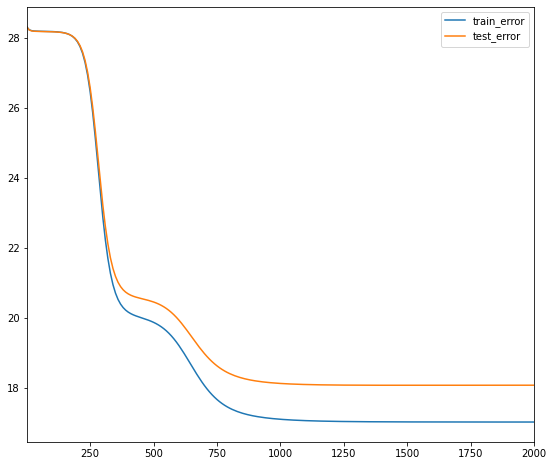

In [200]:
# Build the CF model and train it.
model = build_model(df_joke3,number_users+1,number_joke, embedding_dim=2, init_stddev=0.5)
model.train(num_iterations=2000, learning_rate=10.)

# Inspeccionando los Embebidos


### Recomendacion al usuario

Recomendación al usuario a partir de las calificaciones de los chistes.

In [201]:
rec_cosine = user_recommendations(model, COSINE, k=10)

,cosine score,joke_id,jokes,genres
94,1.000,94,Just a thought ..\n<p>\nBefore criticizing som...,Social-Cultures-Country
76,1.000,76,If pro- is the opposite of con- then congress ...,Politics
0,1.000,0,"A man visits the doctor. The doctor says ""I ha...",Health
24,1.000,24,Two kindergarten girls were talking outside: o...,Sex-Social
21,0.999,21,A duck walks into a pharmacy and asks for a co...,Animals-Sex
69,0.999,69,"Employer to applicant: ""In this job we need so...",Professions-job
9,0.999,9,"Two cannibals are eating a clown, one turns to...",Food-Social-Others
81,0.999,81,Q: How do you keep a computer programmer in th...,STEM-Professions-job
1,0.999,1,This couple had an excellent relationship goin...,Relationships
84,0.998,84,Q: How many Presidents does it take to screw i...,Politics-Things-ChangeLightbulb


In [202]:
rec_dot = user_recommendations(model, DOT, k=10)

,dot score,joke_id,jokes,genres
29,6.505,29,Q: What's the difference between a Lawyer and ...,Politics-Things
51,6.443,51,Q: What do Monica Lewinsky and Bob Dole have i...,Politics-Famous-Sex
50,6.397,50,Did you hear that Clinton has announced there ...,Politics-Famous
11,6.390,11,A guy stood over his tee shot for what seemed ...,Relationships-Sports-Others
13,6.342,13,The father was very anxious to marry off his o...,Relationships-Family
21,6.341,21,A duck walks into a pharmacy and asks for a co...,Animals-Sex
40,6.282,40,What does an atheist say during an orgasm?\n<p...,Religion-Sex
77,6.260,77,Q: What's the difference between the governmen...,Politics
72,6.256,72,Q: What is the difference between George Wash...,Politics-Famous
79,6.211,79,"Hillary, Bill Clinton and the Pope are sitting...",Politics-Famous-Religion


Al calificar 35 chistes de los 100. Se puede observar que los chistes por medio del método de producto punto da una mayor recomendación en chiste relacionados con politica y cultura-paises. Mientras que los chistes obtenidos por método de coseno, sugiere chistes relacionados con STEM y profesiones-trabajo. 

Se descargan los 10 resultados obtenidos por medio del método de producto punto y coseno

In [203]:
from google.colab import files
with pd.ExcelWriter('joke_recomendation.xlsx') as writer: 
  rec_dot.to_excel(writer,sheet_name='rec_dot') 
  rec_cosine.to_excel(writer,sheet_name='rec_cosine') 
files.download('joke_recomendation.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Recomedación a partir de una palabra relacionada

En este caso se quiere buscar chiste relacionados a la palabra **engineer**


In [ ]:
rec_cosine_n,df_matching = joke_neighbors(model, "engineer", COSINE, k=15)

El chiste mas cercano : A mechanical, electrical and a software engineer from Microsoft were
driving through the desert when the car broke down. The mechanical
engineer said "It seems to be a problem with the fuel injection system,
why don't we pop the hood and I'll take a look at it." To which the
electrical engineer replied, "No I think it's just a loose ground wire,
I'll get out and take a look." Then, the Microsoft engineer jumps in.
"No, no, no. If we just close up all the windows, get out, wait a few
minutes, get back in, and then reopen the windows everything will work
fine..
[Se encuentra mas de un chiste cercano. El total de chistes relacionados: 6]


,cosine score,joke_id,jokes,genres
27,1.000,27,"A mechanical, electrical and a software engine...",STEM-Professions-job
5,1.000,5,Bill & Hillary are on a trip back to Arkansas....,Politics-Relationships-Famous
90,1.000,90,A Panda bear walks into a bar. Sits down at a...,Animals
11,1.000,11,A guy stood over his tee shot for what seemed ...,Relationships-Sports-Others
10,1.000,10,"Q. What do a hurricane, a tornado, and a redne...",STEM-Relationships-Cultures-Country-Others
...,...,...,...,...
45,0.998,45,<p>A couple has been married for 75 years. For...,Relationships-Sex
86,0.998,86,"A man, recently completing a routine physical ...",Health
77,0.998,77,Q: What's the difference between the governmen...,Politics
38,0.996,38,What is the difference between men and women:\...,Relationships-Sex


In [ ]:
rec_dot_n,df_matching = joke_neighbors(model, "engineer", DOT, k=15)

El chiste mas cercano : A mechanical, electrical and a software engineer from Microsoft were
driving through the desert when the car broke down. The mechanical
engineer said "It seems to be a problem with the fuel injection system,
why don't we pop the hood and I'll take a look at it." To which the
electrical engineer replied, "No I think it's just a loose ground wire,
I'll get out and take a look." Then, the Microsoft engineer jumps in.
"No, no, no. If we just close up all the windows, get out, wait a few
minutes, get back in, and then reopen the windows everything will work
fine..
[Se encuentra mas de un chiste cercano. El total de chistes relacionados: 6]


,dot score,joke_id,jokes,genres
60,35.889,60,"<p>During a recent publicity outing, Hillary s...",Politics-Others
53,35.837,53,"The Pope dies and, naturally, goes to heaven. ...",Religion-Sex
61,35.631,61,A group of managers were given the assignment...,STEM-Professions-job
88,35.626,88,<i>A radio conversation of a US naval \nship w...,Cultures-Country
49,35.224,49,A guy goes into confession and says to the pri...,Religion-Sex-Cultures-Country
...,...,...,...,...
26,34.602,26,Clinton returns from a vacation in Arkansas an...,Politics-Relationships-Famous
20,34.563,20,What's the difference between a used tire and ...,Sex-Things
31,34.479,31,A man arrives at the gates of heaven. St. Pete...,Religion
65,34.051,65,"A lawyer opened the door of his BMW, when sudd...",Health-Things-Professions-job


Al buscar chistes relacionados a la palabra **engineer**

- El algoritmo obtiene 6 chistes relacionados con la palabra engineer. Sin embargo, busca los chistes de acuerdo al primer chiste encontrado el cual fue:

  - "*A mechanical, electrical and a software engineer from Microsoft were
driving through the desert when the car broke down. The mechanical
engineer said "It seems to be a problem with the fuel injection system,
why don't we pop the hood and I'll take a look at it." To which the
electrical engineer replied, "No I think it's just a loose ground wire,
I'll get out and take a look." Then, the Microsoft engineer jumps in.
"No, no, no. If we just close up all the windows, get out, wait a few
minutes, get back in, and then reopen the windows everything will work
fine.."*

Se puede observar que los chistes por medio del método de producto punto da una mayor recomendación en chiste relacionados con politica, sexo, y STEM. Mientras que los chistes obtenidos por método de coseno, sugiere chistes relacionados con STEM y relaciones. 



Se descargan los resultados obtenidos por medio del método de producto punto y coseno, a partir del chiste relacionado con la palabra *engineer*

In [ ]:
from google.colab import files
with pd.ExcelWriter('joke_neighbors_rec.xlsx') as writer: 
  df_matching.to_excel(writer,sheet_name='Chiste_relacionado') 
  rec_dot_n.to_excel(writer,sheet_name='rec_n_dot') 
  rec_cosine_n.to_excel(writer,sheet_name='rec_n_cosine') 
files.download('joke_neighbors_rec.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Joke Embedding Norm

La recomendaciones con producto punto y coseno son diferentes.

- Con producto punto, el modelo tiende a recomendar chistes populares. Esto puede explicarse por el hecho de que en los modelos de factorización matricial, la norma del embebido a menudo se correlaciona con la popularidad (las chistes populares tienen mayor norma), lo que hace que sea más probable recomendar elementos más populares. Podemos confirmar esta hipótesis ordenando los chistes por su norma de incrustación, como se hace en la siguiente celda.

In [90]:
joke_rating[['joke_id','joke', 'rating count', 'rating mean']].sort_values('rating count').head()

,joke_id,joke,rating count,rating mean
70,70,"At a recent Sacramento PC Users Group meeting,...",8532,-0.687
72,72,Q: What is the difference between George Wash...,8616,1.082
71,71,"On the first day of college, the Dean addresse...",8693,2.757
73,73,Q: How many stalkers does it take to change a ...,8761,-1.554
74,74,Q: Do you know the difference between an intel...,8793,-0.271


In [59]:
joke_embedding_norm(model)

alt.HConcatChart(...)

## Modelo con baja desviación estandar 

Dependiendo de cómo se inicialice el modelo, se puede observar que los chistes que tienen pocas calificaciones tienen una norma alta, lo que genera recomendaciones falsas. Lo cual sucede cuando el embebido del chiste se inicializa con una norma alta. Luego, debido a que el chiste tiene pocas calificaciones, se actualiza con poca frecuencia y puede mantener su alta norma. Esto se aliviará mediante la regularización.

Creación del modelo con regularización. Parámetros utilizados:

- Base: df_joke3
- Cantidad de usuario: 24984
- Cantidad de chistes : 100

Hiperparámetros:

- embedding_dim: 2
- init_stddev: 0.01

Al disminuir el hyper parametro `init_stddev`, se realiza la regularización en el modelo para datos con una norma alta.



 iteration 2000: train_error=17.014648, test_error=18.128447

[{'test_error': 18.128447, 'train_error': 17.014648}]

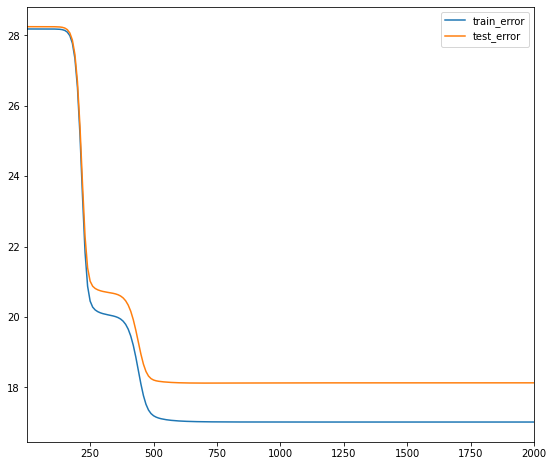

In [54]:
model_lowinit = build_model(df_joke3,number_users+1,number_joke, embedding_dim=2, init_stddev=0.01)
model_lowinit.train(num_iterations=2000, learning_rate=10.)

### Recomendacion al usuario

Recomendación al usuario a partir de las calificaciones de los chistes.

In [55]:
rec_cos_lowinit = user_recommendations(model_lowinit, COSINE, k=10)

,cosine score,joke_id,jokes,genres
89,1.000,89,Q: How many programmers does it take to change...,STEM-Things-Professions-job-ChangeLightbulb
18,1.000,18,Q: If a person who speaks three languages is c...,STEM-Languages-Cultures-Country
51,1.000,51,Q: What do Monica Lewinsky and Bob Dole have i...,Politics-Famous-Sex
78,1.000,78,Q: Ever wonder why the IRS calls it Form 1040?...,Politics
62,1.000,62,"An engineer, a physicist and a mathematician a...",STEM-Professions-job
54,0.999,54,"A woman has twins, and gives them up for adopt...",Family
93,0.998,93,Two atoms are walking down the street when one...,STEM
83,0.998,83,Q: What is the difference between Mechanical E...,STEM-Professions-job
81,0.995,81,Q: How do you keep a computer programmer in th...,STEM-Professions-job
1,0.994,1,This couple had an excellent relationship goin...,Relationships


In [56]:
rec_dot_lowinit = user_recommendations(model_lowinit, DOT, k=10)

,dot score,joke_id,jokes,genres
29,7.170,29,Q: What's the difference between a Lawyer and ...,Politics-Things
8,7.090,8,A country guy goes into a city bar that has a ...,Food-Cultures-Country
3,7.061,3,Q. What's the difference between a man and a t...,Relationships
23,7.010,23,What do you get when you run over a parakeet w...,Languages-Social
40,7.007,40,What does an atheist say during an orgasm?\n<p...,Religion-Sex
32,6.973,32,What do you call an American in the finals of ...,Sports-Cultures-Country
50,6.924,50,Did you hear that Clinton has announced there ...,Politics-Famous
58,6.906,58,The Chukcha (Russian Eskimo) phones up the Rus...,Politics
66,6.781,66,"Once upon a time, two brooms fell in love and ...",Sex
42,6.756,42,Arnold Swartzeneger and Sylvester Stallone are...,Famous


Al calificar 35 chistes de los 100. Se puede observar que los chistes por medio del método de producto punto da una mayor recomendación en chiste relacionados con politica y cultura-paises. Mientras que los chistes obtenidos por método de coseno, sugiere chistes relacionados con STEM y profesiones-trabajo. 

Se descargan en excel las recomendaciones obtenidas

In [ ]:
from google.colab import files
with pd.ExcelWriter('joke_rec_model_lowinit.xlsx') as writer: 
  rec_dot_lowinit.to_excel(writer,sheet_name='rec_dot') 
  rec_cos_lowinit.to_excel(writer,sheet_name='rec_cosine') 
files.download('joke_rec_model_lowinit.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Recomedación a partir de una palabra relacionada

En este caso se quiere buscar chiste relacionados a la palabra **engineer**

In [57]:
n_rec_cos_lowinit, df_related = joke_neighbors(model_lowinit, "engineer", COSINE,k=15)


El chiste mas cercano : A mechanical, electrical and a software engineer from Microsoft were
driving through the desert when the car broke down. The mechanical
engineer said "It seems to be a problem with the fuel injection system,
why don't we pop the hood and I'll take a look at it." To which the
electrical engineer replied, "No I think it's just a loose ground wire,
I'll get out and take a look." Then, the Microsoft engineer jumps in.
"No, no, no. If we just close up all the windows, get out, wait a few
minutes, get back in, and then reopen the windows everything will work
fine..
[Se encuentra mas de un chiste cercano. El total de chistes relacionados: 6]


,cosine score,joke_id,jokes,genres
27,1.000,27,"A mechanical, electrical and a software engine...",STEM-Professions-job
90,1.000,90,A Panda bear walks into a bar. Sits down at a...,Animals
5,1.000,5,Bill & Hillary are on a trip back to Arkansas....,Politics-Relationships-Famous
11,1.000,11,A guy stood over his tee shot for what seemed ...,Relationships-Sports-Others
10,1.000,10,"Q. What do a hurricane, a tornado, and a redne...",STEM-Relationships-Cultures-Country-Others
...,...,...,...,...
46,0.998,46,There was an engineer who had an exceptional g...,STEM-Professions-job
45,0.997,45,<p>A couple has been married for 75 years. For...,Relationships-Sex
77,0.996,77,Q: What's the difference between the governmen...,Politics
38,0.994,38,What is the difference between men and women:\...,Relationships-Sex


In [58]:
n_rec_dot_lowinit, df_related = joke_neighbors(model_lowinit, "engineer", DOT,k=15)

El chiste mas cercano : A mechanical, electrical and a software engineer from Microsoft were
driving through the desert when the car broke down. The mechanical
engineer said "It seems to be a problem with the fuel injection system,
why don't we pop the hood and I'll take a look at it." To which the
electrical engineer replied, "No I think it's just a loose ground wire,
I'll get out and take a look." Then, the Microsoft engineer jumps in.
"No, no, no. If we just close up all the windows, get out, wait a few
minutes, get back in, and then reopen the windows everything will work
fine..
[Se encuentra mas de un chiste cercano. El total de chistes relacionados: 6]


,dot score,joke_id,jokes,genres
88,71.977,88,<i>A radio conversation of a US naval \nship w...,Cultures-Country
53,71.619,53,"The Pope dies and, naturally, goes to heaven. ...",Religion-Sex
49,71.448,49,A guy goes into confession and says to the pri...,Religion-Sex-Cultures-Country
60,71.396,60,"<p>During a recent publicity outing, Hillary s...",Politics-Others
61,71.288,61,A group of managers were given the assignment...,STEM-Professions-job
...,...,...,...,...
68,69.626,68,"This guys wife asks, ""Honey if I died would yo...",Relationships-Family-Sex-Social
31,69.439,31,A man arrives at the gates of heaven. St. Pete...,Religion
20,68.165,20,What's the difference between a used tire and ...,Sex-Things
65,67.887,65,"A lawyer opened the door of his BMW, when sudd...",Health-Things-Professions-job


Al buscar chistes relacionados a la palabra **engineer**

Se puede observar que los chistes por medio del método de producto punto da una mayor recomendación en chiste relacionados con politica, sexo, y STEM. Mientras que los chistes obtenidos por método de coseno, sugiere chistes relacionados con STEM y relaciones. 

Adicionalmente, comparando el modelo alta desviación estandar (primer modelo) con respecto el modelo con baja desviación estandar; se puede observar que el resultado del producto es mayor en el modelo con baja desviación estandar.

Se descargan en excel las recomendaciones relacionadas con el chiste de la palabra *engineer*

In [ ]:
from google.colab import files
with pd.ExcelWriter('neighbor_joke_rec_model_lowinit.xlsx') as writer: 
  df_matching.to_excel(writer,sheet_name='Chiste_relacionado') 
  n_rec_dot_lowinit.to_excel(writer,sheet_name='rec_dot') 
  n_rec_cos_lowinit.to_excel(writer,sheet_name='rec_cosine') 
files.download('neighbor_joke_rec_model_lowinit.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:
joke_embedding_norm([model, model_lowinit])

alt.HConcatChart(...)

In [67]:
tsne_joke_embeddings(model_lowinit)

Running t-SNE...
[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.240265
[t-SNE] KL divergence after 250 iterations with early exaggeration: 37.262630
[t-SNE] KL divergence after 400 iterations: 0.047801


alt.HConcatChart(...)

## Modelo con Regularización en la factorización de la matriz

La regularización resalta una tensión entre ajustar los datos observados y minimizar los términos de regularización. 

Creación del modelo con regularización. Parámetros utilizados:

- Base: df_joke3
- Cantidad de usuario: 24984
- Cantidad de chistes : 100

Hiperparámetros:

- embedding_dim: 35
- init_stddev: 0.01
- regularization_coeff: 0.05
- gravity_coeff: 0.1.

Al disminuir el hyper parametro `init_stddev`, se realiza la regularización en el modelo para datos con una norma alta.



In [204]:
reg_model = build_regularized_model(
    df_joke3, number_users+1,number_joke,regularization_coeff=0.05, gravity_coeff=0.1, embedding_dim=3,
    init_stddev=0.01,)

 iteration 2000: train_error_observed=16.235386, test_error_observed=17.642307, observed_loss=16.235386, regularization_loss=0.522308, gravity_loss=0.862597

[{'test_error_observed': 17.642307, 'train_error_observed': 16.235386},
 {'gravity_loss': 0.86259675,
  'observed_loss': 16.235386,
  'regularization_loss': 0.52230805}]

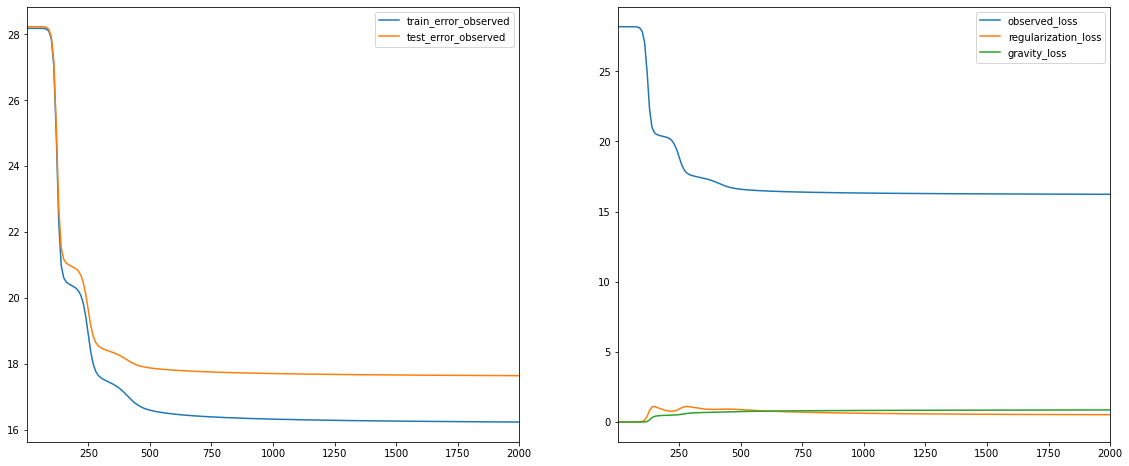

In [205]:
reg_model.train(num_iterations=2000, learning_rate=20.)

### Recomendacion al usuario

Recomendación al usuario a partir de las calificaciones de los chistes.

In [206]:
rec_cos_regm = user_recommendations(reg_model, COSINE, k=10)

,cosine score,joke_id,jokes,genres
54,0.999,54,"A woman has twins, and gives them up for adopt...",Family
22,0.993,22,Q: What is the Australian word for a boomerang...,Languages-Cultures-Country
78,0.977,78,Q: Ever wonder why the IRS calls it Form 1040?...,Politics
9,0.966,9,"Two cannibals are eating a clown, one turns to...",Food-Social-Others
0,0.965,0,"A man visits the doctor. The doctor says ""I ha...",Health
76,0.960,76,If pro- is the opposite of con- then congress ...,Politics
58,0.938,58,The Chukcha (Russian Eskimo) phones up the Rus...,Politics
98,0.936,98,A bus station is where a bus stops.<br>\nA tra...,Things
69,0.935,69,"Employer to applicant: ""In this job we need so...",Professions-job
37,0.934,37,"""May I take your order?"" the waiter asked. \n<...",Food-Animals


In [207]:
rec_dot_regm = user_recommendations(reg_model, DOT, k=10)

,dot score,joke_id,jokes,genres
8,5.667,8,A country guy goes into a city bar that has a ...,Food-Cultures-Country
62,5.644,62,"An engineer, a physicist and a mathematician a...",STEM-Professions-job
56,5.579,56,Why are there so many Jones's in the phone boo...,Social
58,5.564,58,The Chukcha (Russian Eskimo) phones up the Rus...,Politics
29,5.551,29,Q: What's the difference between a Lawyer and ...,Politics-Things
66,5.425,66,"Once upon a time, two brooms fell in love and ...",Sex
42,5.409,42,Arnold Swartzeneger and Sylvester Stallone are...,Famous
59,5.408,59,What did the Buddhist say to the hot dog vendo...,Religion-Food
23,5.285,23,What do you get when you run over a parakeet w...,Languages-Social
22,5.277,22,Q: What is the Australian word for a boomerang...,Languages-Cultures-Country


In [208]:
from google.colab import files
with pd.ExcelWriter('joke_rec_model_regm.xlsx') as writer: 
  rec_dot_regm.to_excel(writer,sheet_name='rec_dot') 
  rec_cos_regm.to_excel(writer,sheet_name='rec_cosine') 
files.download('joke_rec_model_regm.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Recomedación a partir de una palabra relacionada

En este caso se quiere buscar chiste relacionados a la palabra **engineer**

In [209]:
n_rec_cos_regm, df_related = joke_neighbors(reg_model, "engineer", COSINE, k=15)

El chiste mas cercano : A mechanical, electrical and a software engineer from Microsoft were
driving through the desert when the car broke down. The mechanical
engineer said "It seems to be a problem with the fuel injection system,
why don't we pop the hood and I'll take a look at it." To which the
electrical engineer replied, "No I think it's just a loose ground wire,
I'll get out and take a look." Then, the Microsoft engineer jumps in.
"No, no, no. If we just close up all the windows, get out, wait a few
minutes, get back in, and then reopen the windows everything will work
fine..
[Se encuentra mas de un chiste cercano. El total de chistes relacionados: 6]


,cosine score,joke_id,jokes,genres
27,1.000,27,"A mechanical, electrical and a software engine...",STEM-Professions-job
46,0.992,46,There was an engineer who had an exceptional g...,STEM-Professions-job
87,0.987,87,A Czechoslovakian man felt his eyesight was gr...,Health
90,0.982,90,A Panda bear walks into a bar. Sits down at a...,Animals
47,0.978,47,"The graduate with a Science degree asks, ""Why ...",STEM-Professions-job
...,...,...,...,...
96,0.956,96,A teacher is explaining to her class how diffe...,STEM-Languages
75,0.937,75,There once was a man and a woman that both go...,Things-Social
67,0.925,67,A man piloting a hot air balloon discovers he ...,Professions-job
37,0.925,37,"""May I take your order?"" the waiter asked. \n<...",Food-Animals


In [210]:
n_rec_dot_regm, df_related = joke_neighbors(reg_model, "engineer", DOT, k=15)

El chiste mas cercano : A mechanical, electrical and a software engineer from Microsoft were
driving through the desert when the car broke down. The mechanical
engineer said "It seems to be a problem with the fuel injection system,
why don't we pop the hood and I'll take a look at it." To which the
electrical engineer replied, "No I think it's just a loose ground wire,
I'll get out and take a look." Then, the Microsoft engineer jumps in.
"No, no, no. If we just close up all the windows, get out, wait a few
minutes, get back in, and then reopen the windows everything will work
fine..
[Se encuentra mas de un chiste cercano. El total de chistes relacionados: 6]


,dot score,joke_id,jokes,genres
61,9.326,61,A group of managers were given the assignment...,STEM-Professions-job
67,8.814,67,A man piloting a hot air balloon discovers he ...,Professions-job
88,8.435,88,<i>A radio conversation of a US naval \nship w...,Cultures-Country
31,8.262,31,A man arrives at the gates of heaven. St. Pete...,Religion
27,7.962,27,"A mechanical, electrical and a software engine...",STEM-Professions-job
...,...,...,...,...
92,7.134,92,"Reaching the end of a job interview, the human...",Professions-job
96,7.019,96,A teacher is explaining to her class how diffe...,STEM-Languages
34,6.956,34,An explorer in the deepest Amazon suddenly fin...,Religion-Languages-Cultures-Country
93,6.946,93,Two atoms are walking down the street when one...,STEM


In [211]:
from google.colab import files
with pd.ExcelWriter('neighbor_joke_rec_model_regm.xlsx') as writer: 
  df_related.to_excel(writer,sheet_name='Chiste_relacionado') 
  n_rec_dot_regm.to_excel(writer,sheet_name='rec_dot') 
  n_rec_cos_regm.to_excel(writer,sheet_name='rec_cosine') 
files.download('neighbor_joke_rec_model_regm.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [130]:
joke_embedding_norm([model, model_lowinit, reg_model])

alt.HConcatChart(...)

In [131]:
# Visualize the embeddings
tsne_joke_embeddings(reg_model)

Running t-SNE...
[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.357682
[t-SNE] KL divergence after 250 iterations with early exaggeration: 39.900139
[t-SNE] KL divergence after 400 iterations: 0.109144


alt.HConcatChart(...)

# IV. Softmax model

Por medio de un modelo de soft model se predicirá a partir de las peliculas calificadas de un usuario.

En el modelo se toma como entrada el vector $x$, el cual representa la lista de los chistes que los usuarios han calificado.

Por lo tando se toma el datafram `df_joke3` el cual contiene el id de los usuarios, el id de los chistes, y el rating por chiste. Se agrupan los usuarios y se genera una lista de los chistes que calificaro.

In [97]:
rated_jokes = (df_joke3[["user_id", "joke_id"]]
                .groupby("user_id", as_index=False)
                .aggregate(lambda x: list(x)))
rated_jokes.head()

,user_id,joke_id
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,10,"[0, 1, 4, 6, 7, 9, 12, 14, 15, 16, 17, 18, 19,..."
3,100,"[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 1..."
4,1000,"[4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17..."


Se crea una función que genera un batch de ejemplo, donde cada ejemplo contien las siguientes caracteristicas:

- joke_id: Un tensor de strings de los ids de los chistes que cada usuario calificó.
- genre: Un tensor de strings que tiene los generos de los chistes.

In [98]:
genres_dict = {
    joke: genres.split('-')
    for joke, genres in zip(joke_genre["joke_id"], joke_genre["all_genres"])
}

### Entrenamiento del modelo Softmax

Se realiza el entranmiento del modelo de softmax. 
Base utilizada:
- rated_jokes

Los hiperparametros utilizados son:

- learning rate: 5
- number of iterations:3000
- hidden_dims: 35

 iteration 3000: train_loss=4.380168, test_loss=4.339750, test_precision_at_10=0.015198

({'test_loss': 4.3397503, 'train_loss': 4.380168},
 {'test_precision_at_10': 0.015198267244251915})

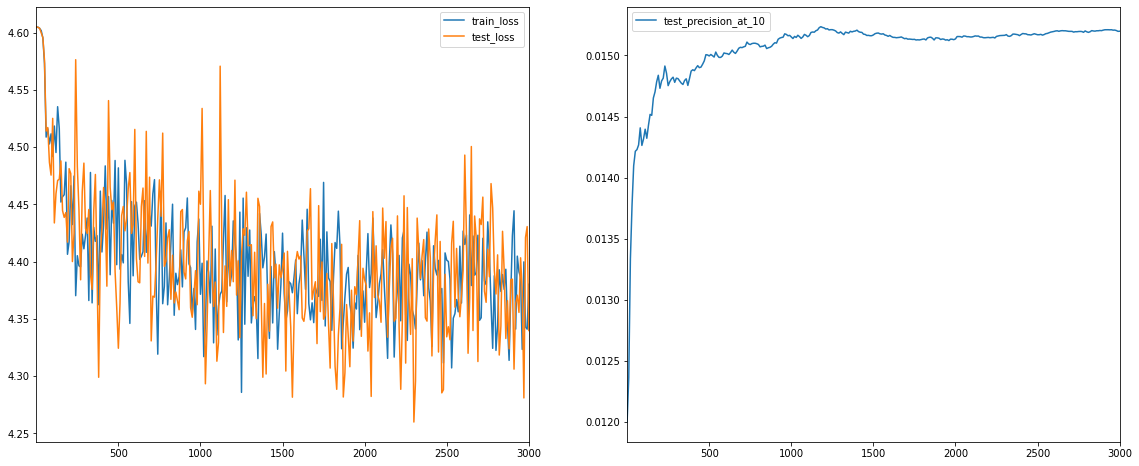

In [123]:
# Create feature embedding columns
def make_embedding_col(key, embedding_dim):
  categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
      key=key, vocabulary_list=list(set(joke_genre[key].values)), num_oov_buckets=0)
  return tf.feature_column.embedding_column(
      categorical_column=categorical_col, dimension=embedding_dim,
      # default initializer: trancated normal with stddev=1/sqrt(dimension)
      combiner='mean')
with tf.Graph().as_default():
  softmax_model = build_softmax_model(
      rated_jokes,
      embedding_cols=[
          make_embedding_col("joke_id", 35),
          make_embedding_col("genre", 3),
      ],
      hidden_dims=[35])
softmax_model.train(learning_rate=5., num_iterations=3000, optimizer=tf.train.AdagradOptimizer)

### Recomedación a partir de una palabra relacionada

En este caso se quiere buscar chiste relacionados a la palabra **engineer**

In [135]:
soft_rec_cos_n,soft_df_matching = joke_neighbors(softmax_model, "engineer", COSINE, k=15)

El chiste mas cercano : A mechanical, electrical and a software engineer from Microsoft were
driving through the desert when the car broke down. The mechanical
engineer said "It seems to be a problem with the fuel injection system,
why don't we pop the hood and I'll take a look at it." To which the
electrical engineer replied, "No I think it's just a loose ground wire,
I'll get out and take a look." Then, the Microsoft engineer jumps in.
"No, no, no. If we just close up all the windows, get out, wait a few
minutes, get back in, and then reopen the windows everything will work
fine..
[Se encuentra mas de un chiste cercano. El total de chistes relacionados: 6]


,cosine score,joke_id,jokes,genres
27,1.000,27,"A mechanical, electrical and a software engine...",STEM-Professions-job
47,0.934,47,"The graduate with a Science degree asks, ""Why ...",STEM-Professions-job
15,0.929,15,Q. What is orange and sounds like a parrot? <...,STEM-Food
28,0.914,28,An old Scotsmen is sitting with a younger Scot...,Politics-Sex-Things-Cultures-Country
49,0.913,49,A guy goes into confession and says to the pri...,Religion-Sex-Cultures-Country
...,...,...,...,...
18,0.881,18,Q: If a person who speaks three languages is c...,STEM-Languages-Cultures-Country
55,0.873,55,A man and Cindy Crawford get stranded on a des...,Famous-Sex-Social
14,0.873,14,Q: What did the blind person say when given s...,Health-Cultures-Country
34,0.855,34,An explorer in the deepest Amazon suddenly fin...,Religion-Languages-Cultures-Country


In [136]:
soft_rec_dot_n,soft_df_matching = joke_neighbors(softmax_model, "engineer", DOT, k=15)

El chiste mas cercano : A mechanical, electrical and a software engineer from Microsoft were
driving through the desert when the car broke down. The mechanical
engineer said "It seems to be a problem with the fuel injection system,
why don't we pop the hood and I'll take a look at it." To which the
electrical engineer replied, "No I think it's just a loose ground wire,
I'll get out and take a look." Then, the Microsoft engineer jumps in.
"No, no, no. If we just close up all the windows, get out, wait a few
minutes, get back in, and then reopen the windows everything will work
fine..
[Se encuentra mas de un chiste cercano. El total de chistes relacionados: 6]


,dot score,joke_id,jokes,genres
47,10.297,47,"The graduate with a Science degree asks, ""Why ...",STEM-Professions-job
65,10.090,65,"A lawyer opened the door of his BMW, when sudd...",Health-Things-Professions-job
27,9.788,27,"A mechanical, electrical and a software engine...",STEM-Professions-job
15,9.780,15,Q. What is orange and sounds like a parrot? <...,STEM-Food
25,9.376,25,A guy walks into a bar and sits down next to a...,Relationships-Social
...,...,...,...,...
16,8.962,16,How many men does it take to screw in a light ...,STEM-Things-ChangeLightbulb
49,8.676,49,A guy goes into confession and says to the pri...,Religion-Sex-Cultures-Country
34,8.451,34,An explorer in the deepest Amazon suddenly fin...,Religion-Languages-Cultures-Country
46,8.059,46,There was an engineer who had an exceptional g...,STEM-Professions-job


In [212]:
from google.colab import files
with pd.ExcelWriter('neighbor_joke_rec_model_softmax.xlsx') as writer: 
  soft_df_matching.to_excel(writer,sheet_name='Chiste_relacionado') 
  soft_rec_dot_n.to_excel(writer,sheet_name='rec_dot') 
  soft_rec_cos_n.to_excel(writer,sheet_name='rec_cosine') 
files.download('neighbor_joke_rec_model_softmax.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [138]:
joke_embedding_norm([reg_model, softmax_model])

alt.HConcatChart(...)

In [141]:
tsne_joke_embeddings(softmax_model)

Running t-SNE...
[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.516914
[t-SNE] KL divergence after 250 iterations with early exaggeration: 40.812275
[t-SNE] KL divergence after 400 iterations: 0.069095


alt.HConcatChart(...)

# V. Conclusiones

Al ver la gráfica de `tsne_joke_embeddings` entre el **modelo softmax** y el **modelo de  factorización de matrices con regularización**. Se puede observar que en el modelo softmax se encuentran mas chistes con genero similar en coordenadas mas cercanas que en el modelo de factorización de matrices con regularización.
- Adicionalmente, al ver los chistes recomendados obtenidos por cada modelo, se puede observar que el modelo de softmax genera mas chistes relacionados al genero de STEM y Profesiones-trabajo, los cuales son los géneros que tiene el chiste con el tema de *engineer*.

Por lo tanto, se considera que el modelo de softmax se considera mejor en la base de chistes.

Para obtener resultados mas precisos se recomendaría aumentar la cantidad de chistes en la base de datos para que hayan mas chistes similares para recomendar.

# VI. De Tensorflow. 1.x, a Tensorflow. 2.x,

- Las funciones que se utilizan en **Modelos clásicos por factorización de matrices** se encuentran ya transformadas en Tensorflow 2.x

- Las funciones que se utilizan en el **Modelo de Softmax** tienen partes en Tensorflow 1.x. 

  - En la funcion `build_softmax_model` se puede transformar a Tensorflow. 2.x
    - Tensorflow. 1.x
```
for i, output_dim in enumerate(hidden_dims):
      w = tf.get_variable(
          "hidden%d_w_" % i, shape=[input_dim, output_dim],
          initializer=tf.truncated_normal_initializer(
              stddev=1./np.sqrt(output_dim))) / 10.
      outputs = tf.matmul(inputs, w)
      input_dim = output_dim
      inputs = outputs
    return outputs
```
    - Tensorflow. 2.x
```
for i, output_dim in enumerate(hidden_dims):
      w = tf.Variable(tf.truncated_normal_initializer(
              stddev=1./np.sqrt(output_dim)), 
              name = "hidden%d_w_" % i, shape=tf.TensorShape([input_dim, output_dim])) / 10.
      outputs = tf.matmul(inputs, w)
      input_dim = output_dim
      inputs = outputs
    return outputs
```